<h1 style="color: #5ca3d6; text-align: center;">Classifying Severity of Alzheimer's Disease - CNN</h1>

In [1]:
import numpy as np
import cv2
import os

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

<h3 style="font-weight: normal;">Constants</h3>

In [2]:
DATASET_PATH = '..' + os.path.sep + 'dataset'
IMAGE_SIZE = (128, 128)

<h3 style="font-weight: normal;">Reading image paths and labels and writing to dictionary</h3>

Iterrating through dataset's directories and files and creating dictionary with <span style="font-style: italic;">"path/to/file" : "label"</span> pairs. <br/>
Also, creating classes list, which is a list with names of all classes. Possible Alzheimer stages (classes) are: non demented, mild demented, very mild demented and moderate demented.

In [3]:
images_dict = dict()
classes = []

for root, dirs, files in os.walk(DATASET_PATH):
    path = root.split(os.sep)
    for directory in dirs:
        classes.append(directory)

    for file in files:
        if len(path) == 3:
            if path[2] == 'MildDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 0
            elif path[2] == 'ModerateDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 1
            elif path[2] == 'NonDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 2
            elif path[2] == 'VeryMildDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 3

class_number = len(classes)
classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

<h3 style="font-weight: normal;">Loading images</h3>

Creating two lists: <span style="font-style: italic;">train_images</span>, which is a list of loaded images, and <span style="font-style: italic;">train_image_labels</span>, which is a list of labels for each image.

In [4]:
train_images = []
train_image_labels = []

for image_path, image_label in images_dict.items():
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMAGE_SIZE)
    train_images.append(img)
    train_image_labels.append(image_label)
    # print(image_path)

train_images = np.array(train_images, dtype=float)
train_image_labels = np.array(train_image_labels, dtype=float)

<h3 style="font-weight: normal;">Split to train and test</h3>

In [5]:
train_images, test_images, train_image_labels, test_image_labels = train_test_split(
    train_images,
    train_image_labels,
    test_size=0.2,
    random_state=15,
    stratify=train_image_labels)

train_images = train_images / 255
test_images = test_images / 255

<h3 style="font-weight: normal;">Oversampling</h3>

In [6]:
sm = SMOTE(random_state=42)
train_images, train_image_labels = sm.fit_resample(train_images.reshape(-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * 1), 
                                                   train_image_labels)
train_images = train_images.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)


test_images, test_image_labels = sm.fit_resample(test_images.reshape(-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * 1), 
                                                 test_image_labels)
test_images = test_images.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

<h3 style="font-weight: normal;">Shuffling data</h3>

In [7]:
train_images, train_image_labels = shuffle(train_images, train_image_labels)

<h3 style="font-weight: normal;">Creating and training model</h3>

In [8]:
try:
    model = load_model('models/cnn.h5')
except:
    model = Sequential()
    
    model.add(Conv2D(input_shape=IMAGE_SIZE+(1,), filters=64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=class_number, activation='softmax'))
    
    model.summary()

    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_images, train_image_labels, epochs=10, verbose=1)
    model.save('models/cnn.h5')

    # Plotting accuracy and loss during training
    # accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

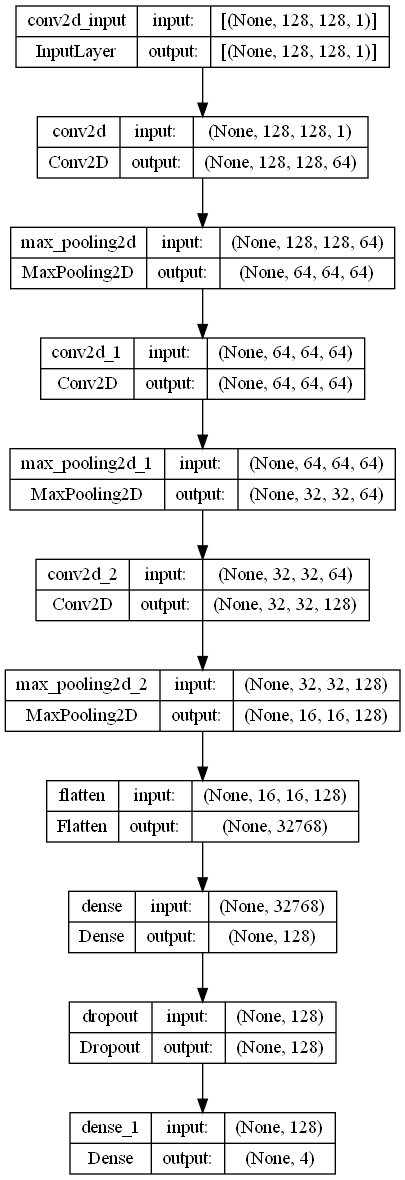

In [9]:
keras.utils.plot_model(model, to_file="models/model_plot.png", show_shapes=True, show_layer_names=True)

<h3 style="font-weight: normal;">Evaluating and predicting</h3>

In [10]:
# Evaluating
results = model.evaluate(test_images, test_image_labels)
print("test loss, test acc:", results)

# Predicting
predictions = model.predict(test_images)
print(predictions)

predicted_labels = []
for prediction in predictions:
    predicted_value = max(prediction)
    index = np.where(prediction == predicted_value)[0][0]
    predicted_labels.append(index)

80/80 [==============================] - 12s 142ms/step - loss: 0.0781 - accuracy: 0.2492
test loss, test acc: [0.07814564555883408, 0.24921874701976776]
80/80 [==============================] - 12s 143ms/step
[[7.5270557e-13 1.2987994e-26 9.9999404e-01 5.9523118e-06]
 [9.1651011e-01 1.6913592e-19 8.3226100e-02 2.6371647e-04]
 [1.3358533e-18 2.1895729e-19 9.9999046e-01 9.5754986e-06]
 ...
 [5.6465022e-04 9.4538042e-15 7.2938120e-03 9.9214149e-01]
 [5.7713227e-12 9.3737471e-09 3.4082439e-04 9.9965918e-01]
 [1.5365760e-04 1.0683921e-12 3.0125510e-03 9.9683386e-01]]


<h2 style="font-weight: normal;">Statistics</h2>

In [11]:
test_image_labels_str = []
for label in test_image_labels:
    test_image_labels_str.append(classes[int(label)])
predicted_labels_str = []
for label in predicted_labels:
    predicted_labels_str.append(classes[label])

<h4 style="font-weight: normal;">Confusion matrix</h4>

[[626   0   2  12]
 [  0 640   0   0]
 [  1   0 619  20]
 [ 11   0  26 603]]


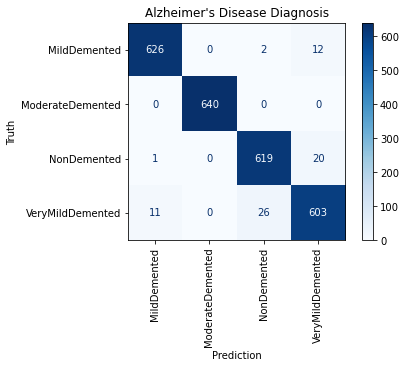

In [12]:
conf_mat = confusion_matrix(test_image_labels_str, predicted_labels_str, labels=classes)
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(cmap="Blues", values_format='', xticks_rotation=90)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

<h4 style="font-weight: normal;">Accuracy</h4>

In [13]:
percentage = accuracy_score(test_image_labels_str, predicted_labels_str)*100
print('Accuracy:', percentage, '%')

Accuracy: 97.1875 %


<h4 style="font-weight: normal;">Classification report</h4>

In [14]:
print(classification_report(y_true=list(map(str, test_image_labels_str)),
                            y_pred=list(map(str, predicted_labels_str)),
                            target_names=list(map(str, classes))))

                  precision    recall  f1-score   support

    MildDemented       0.98      0.98      0.98       640
ModerateDemented       1.00      1.00      1.00       640
     NonDemented       0.96      0.97      0.96       640
VeryMildDemented       0.95      0.94      0.95       640

        accuracy                           0.97      2560
       macro avg       0.97      0.97      0.97      2560
    weighted avg       0.97      0.97      0.97      2560

